In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import cv2

# Some general statistics about the dataset

Number of chapters: 212
Number of manga pages: 6262
Total number of patches: 100172


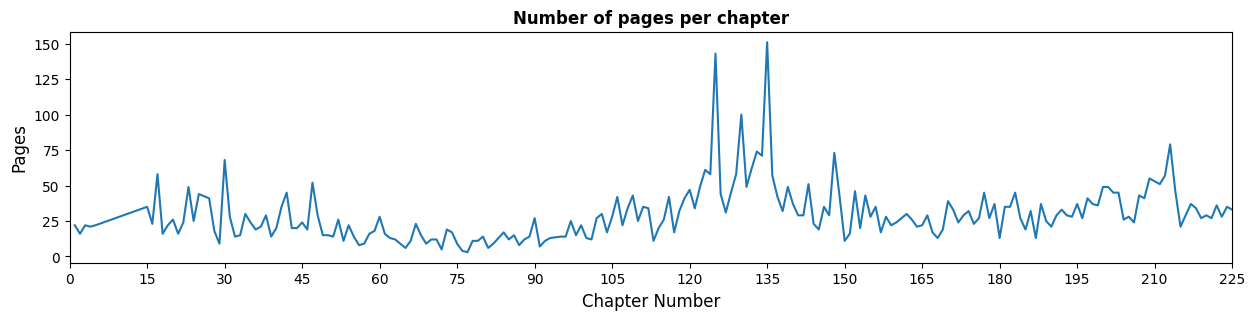

In [2]:
source_dir = 'D:\\OPM\\source\\'
target_dir = 'D:\\OPM\\target\\'

chapters = len(os.listdir(source_dir))
pages = sum(len(files) for subdir, dirs, files in os.walk(source_dir))
page_patches = sum(len(files) for s, d, files in os.walk(target_dir))

print(f'Number of chapters: {chapters}\n'
      f'Number of manga pages: {pages}\n'
      f'Total number of patches: {page_patches}')

chapters = []
pages = []

for subdir in sorted([int(d) for d in os.listdir(source_dir)]):
    chapters.append(subdir)
    pages.append(len(os.listdir(f'{source_dir}{subdir}')))

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(chapters, pages)
ax.set_xlabel('Chapter Number', fontsize=12)
ax.set_ylabel('Pages', fontsize=12)
ax.set_title('Number of pages per chapter', fontsize=12, fontweight='bold')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.set_xlim([0, max(chapters)])
plt.show()

# Dataset insights

**After a visual inspection of the dataset, the following conclusions can be made:**

1. The individual patches of each page have a randomized order, but are not rotated or mirrored.
2. The width of each patch is fixed at 200 pixels. The patch height is varying between either 280 or 312 pixels. Around 15% of the chapters have a patch size of 200 x 312 pixels, while around 85% have a patch height of 280. The size of the patches does not change within a chapter, only between chapters.
3. 4 chapters have no randomized patches and are already in their readable state.
4. 13 chapters contain a single blank page, an entire black page or a few ad pages at the end of the chapter.

**With the above mentioned insights, the following cleaning steps are applied:**

1. The 4 chapters with no randomized pages a will be removed from the dataset.
2. Single blank, entire black pages and pages consisting solely of ads will be removed from the dataset.

Detailed information on the removed chapters and pages can be viewed in the 'dataset_info.csv' file.

The dataset consists, after spliting each page into 16 individual patches, of 100172 images.

**Some thoughts on the dataset**

The problem will now be to find a way to stitch the correct patches together. The patches have no overlapping areas. Therefore algorithms like SIFT (Scale-invariant feature transform) have a hard time finding matching patches. A possible approach could be to interpolate the outer most row/column of each patch to find a fitting candidate. The downside of this approach is, that it is very time consuming and not very efficient. In terms of complexity, we are talking a comparision of each patch with eath other patch of the same page (at least in the worst case scenario). While i am not entirely sure, i suspect we have a complexity of around O(n^2) or even worse.

Furthermore, while we know which 16 patches create a complete page, we don't know what the final page will look like and the patches themselves have no positional label.

So in other words, we have a nice big dataset, but no labels.

I think a possible approach could be an initial grouping of the patches, according to their motive or pixel similarity. From a human viewpoint, solving puzzles involves searching for similarities. Similar colors, patterns, and so on. Therefore the spatial component, or the bigger picture of the patches is important and could be helpful.

# Brute force or classical approach: Vector comparision with the Cosine similarity

We know, that each page is made up of 16 image patches. If we look at the problem on a smaller scale, we are trying to find matching patches.
The necessary steps are:
1. Select a patch as a starting point (maybe with some "unique" feature).
2. Search for another patch with a matching pattern.
3. If the patch is correct, search for the next part with a similar pattern.

Especially step 2. is of interest. How do we define a "matching pattern"? On the high level, we search again for similar features. That can be for example textures or shapes. On the lower level, we are looking at the border region of the patch and look if any other part has a similar feature. 

The question we are asking ourselve is: 
Is the outer right edge of patch A similar to the outer left edge of patch B?

We can translate this step by using statistics. An image is nothing more than a matrix. There are different approached to compare the similarity of different arrays. One of which is the so called Cosine similarity.

For example, let's take the following two patches A and B.

Text(0.5, 1.0, 'Patch B')

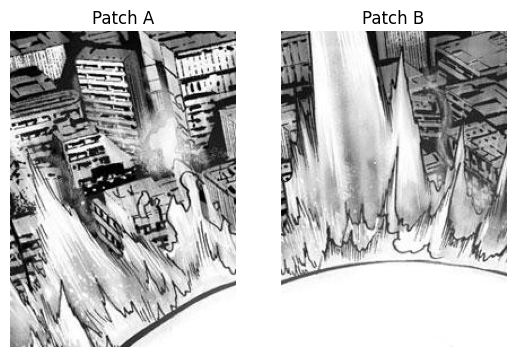

In [3]:
patch_A = cv2.imread('D:\\OPM\\target\\1\\3_8.jpeg', cv2.IMREAD_COLOR)
patch_B = cv2.imread('D:\\OPM\\target\\1\\3_12.jpeg', cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.array(patch_A))
ax[0].axis('off')
ax[0].set_title('Patch A')
ax[1].imshow(np.array(patch_B))
ax[1].axis('off')
ax[1].set_title('Patch B')

Because the two patches are rectangles, we can determine the following potential positions:

-The long sides of patch A can either be to the left of patch B or to the right of batch B.
-The short sides of patch A can either be placed on the top or at the bottom of patch B.

Let's apply the above mentioned cosine similarity to the outer most edge of these patches.

In mathematical terms, the cosine similarity can be represented by the dot product and the magnitude (or length) of two vectors [1]:

$$
  \cos(\theta) = \frac{A * B}{||A|| * ||B||} = \frac{\sum \limits _{i=1} ^{n} A_i * B_i}{\sqrt(\sum \limits _{i=1} ^{n} A_i^2) * \sqrt(\sum \limits _{i=1} ^{n} B_i^2)}
$$

In [4]:
patch_A_gray = cv2.cvtColor(patch_A, cv2.COLOR_BGR2GRAY)
patch_B_gray = cv2.cvtColor(patch_B, cv2.COLOR_BGR2GRAY)

patch_A_right_edge = patch_A_gray[:, -1]
patch_A_left_edge = patch_A_gray[:, 0]

patch_A_lower_edge = patch_A_gray[-1, :]
patch_A_upper_edge = patch_A_gray[0, :]

patch_B_right_edge = patch_B_gray[:, -1]
patch_B_left_edge = patch_B_gray[:, 0]

patch_B_lower_edge = patch_B_gray[-1, :]
patch_B_upper_edge = patch_B_gray[0, :]

cos_sim_upper_lower = np.dot(patch_A_upper_edge, patch_B_lower_edge)/(np.linalg.norm(patch_A_upper_edge)*np.linalg.norm(patch_B_lower_edge))
cos_sim_right_left = np.dot(patch_A_right_edge, patch_B_left_edge)/(np.linalg.norm(patch_A_right_edge)*np.linalg.norm(patch_B_left_edge))
cos_sim_lower_upper = np.dot(patch_A_lower_edge, patch_B_upper_edge)/(np.linalg.norm(patch_A_lower_edge)*np.linalg.norm(patch_B_upper_edge))
cos_sim_left_right = np.dot(patch_A_left_edge, patch_B_right_edge)/(np.linalg.norm(patch_A_left_edge)*np.linalg.norm(patch_B_right_edge))

print(f"""
      Cosine Similarity Score:\n
      Patch A upper edge - Patch B lower edge: {cos_sim_upper_lower}
      Patch A right edge - Patch B left edge: {cos_sim_right_left}
      Patch A lower edge - Patch B upper edge: {cos_sim_lower_upper}
      Patch A left edge - Patch B right edge: {cos_sim_left_right}
      """)


      Cosine Similarity Score:

      Patch A upper edge - Patch B lower edge: 4.009625441964275e-05
      Patch A right edge - Patch B left edge: 2.543244507393453e-06
      Patch A lower edge - Patch B upper edge: 2.8922313352799663e-05
      Patch A left edge - Patch B right edge: 1.5799864598906273e-05
      


It is not easy to understand the relationship between the two patches from just these raw numbers. Furthermore, it can be misleading to compare raw vectors with each other, especially if one vector is very large and another vector is very small. To be able to compare even vectors of different magnitude, we need to scale them to a similar size while keeping the relevant features. This scaling of data to a common comparable size is called normalization and is a very important step in statistics and machine learning. It is important to note, that normalizing a vector does not change it's shape or form. It only changes the scale (or size) of the vector.

One type of normalization is the L1 Norm (also known as Taxicab or Manhatten geometry)[2]. The L1 Norm can be calculated by summarizing the absolute differences of the components of a vector. If we then divide the vector by this calculated norm, we will normalize the vector to a length of 1.

Lets apply the normalization and look at the returned values for the two patches from above again:

In [5]:
def l1_norm(v):
    norm = np.sum(v)

    return v / norm
    
patch_A_gray = cv2.cvtColor(patch_A, cv2.COLOR_BGR2GRAY)
patch_B_gray = cv2.cvtColor(patch_B, cv2.COLOR_BGR2GRAY)

patch_A_right_edge = l1_norm(patch_A_gray[:, -1])
patch_A_left_edge = l1_norm(patch_A_gray[:, 0])

patch_A_lower_edge = l1_norm(patch_A_gray[-1, :])
patch_A_upper_edge = l1_norm(patch_A_gray[0, :])

patch_B_right_edge = l1_norm(patch_B_gray[:, -1])
patch_B_left_edge = l1_norm(patch_B_gray[:, 0])

patch_B_lower_edge = l1_norm(patch_B_gray[-1, :])
patch_B_upper_edge = l1_norm(patch_B_gray[0, :])

cos_sim_upper_lower = np.dot(patch_A_upper_edge, patch_B_lower_edge)/(np.linalg.norm(patch_A_upper_edge)*np.linalg.norm(patch_B_lower_edge))
cos_sim_right_left = np.dot(patch_A_right_edge, patch_B_left_edge)/(np.linalg.norm(patch_A_right_edge)*np.linalg.norm(patch_B_left_edge))
cos_sim_lower_upper = np.dot(patch_A_lower_edge, patch_B_upper_edge)/(np.linalg.norm(patch_A_lower_edge)*np.linalg.norm(patch_B_upper_edge))
cos_sim_left_right = np.dot(patch_A_left_edge, patch_B_right_edge)/(np.linalg.norm(patch_A_left_edge)*np.linalg.norm(patch_B_right_edge))

print(f"""
      Cosine Similarity Score Normalized:\n
      Patch A upper edge - Patch B lower edge: {cos_sim_upper_lower}
      Patch A right edge - Patch B left edge: {cos_sim_right_left}
      Patch A lower edge - Patch B upper edge: {cos_sim_lower_upper}
      Patch A left edge - Patch B right edge: {cos_sim_left_right}
      """)


      Cosine Similarity Score Normalized:

      Patch A upper edge - Patch B lower edge: 0.773691829855694
      Patch A right edge - Patch B left edge: 0.9756742893184437
      Patch A lower edge - Patch B upper edge: 0.7421458035042179
      Patch A left edge - Patch B right edge: 0.8285483951119103
      


The now resulting scores deliver a clearer picture. We can see that the score of the lower edge of patch A and the upper edge of patch B is the lowest. This indicates, that this position is unlikely to be correct. At the same time, the right side of patch A could be the left neighbour of patch B.

Let's look at the images again and explore these results further. Note: The computation above is only taking the outer most row/column into consideration. But to make problem easier to understand, i highlighted a a bigger border area.

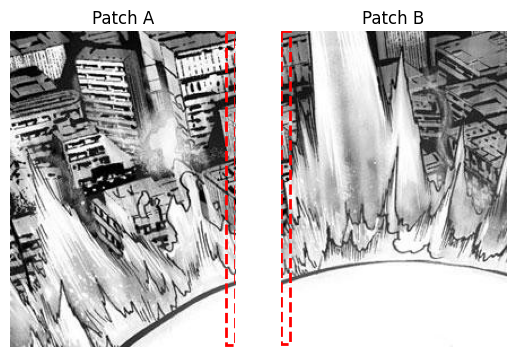

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.array(patch_A))
ax[0].axis('off')
ax[0].set_title('Patch A')
ax[1].imshow(np.array(patch_B))
ax[1].axis('off')
ax[1].set_title('Patch B')

#Lets draw some bounding boxes on the image. The red boxes indicate possible right-left neighbours.
rect = patches.Rectangle(
        (np.array(patch_A).shape[1]-1-8, 0),
        width=8,
        height=np.array(patch_A).shape[0]-2,
        linewidth=2,
        linestyle='--',
        edgecolor='red',
        facecolor='none')
ax[0].add_patch(rect)

rect = patches.Rectangle(
        (0, -1),
        width=8,
        height=np.array(patch_A).shape[0]-2,
        linewidth=2,
        linestyle='--',
        edgecolor='red',
        facecolor='none')
ax[1].add_patch(rect)

While this approach apparently works, we can see another potential problem. Patch B has on the lower edge a white space. What happens now, if another patch has on the upper side also a white space? In this case, we would compare a vector A where almost every value close to 255 to another vector B which element values are also close to 255. The result would be a high score while calculating the similarity score, while at the same time having almost no information value. This edge case needs to be addressed. Furthermore, some pages and panels have black lines or black parts, which can result in the same problematic situation as the just explained white space.

We need to find a way to describe the information density and information value of the to be compared vectors. Mathematically, we can explain a vector with a low information density through the mean and standard deviation. A mean very close to 255 of a black and white image implies that the image is consisting of mostly white pixels. The standard deviation on the other hand shows us how the individual pixel values are distributed within a vector.


      Patch A Upper Edge mean: 74.625 and standard deviation: 61.025
      Patch B Lower Edge mean: 254.830 and standard deviation: 1.327
      


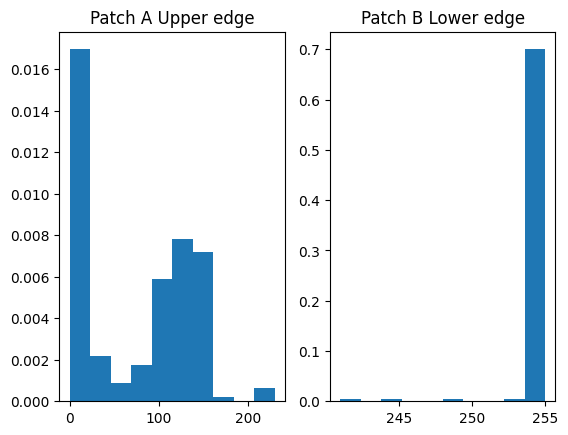

In [7]:
fig1, ax1 = plt.subplots(1, 2)

ax1[0].hist(patch_A_gray[0, :], density=True)
ax1[0].set_title('Patch A Upper edge')
ax1[1].hist(patch_B_gray[-1, :], density=True)
ax1[1].set_title('Patch B Lower edge')

print(f"""
      Patch A Upper Edge mean: {patch_A_gray[0, :].mean():.3f} and standard deviation: {patch_A_gray[0, :].std():.3f}
      Patch B Lower Edge mean: {patch_B_gray[-1, :].mean():.3f} and standard deviation: {patch_B_gray[-1, :].std():.3f}
      """)

As we can see here in the histograms, the upper edge of patch A has a very high standard deviation and a mean of around 74, which matches the gray parts of the image.
On the other hand, patch B has a mean very close to 255, which is the color white in black and white pictures, while also having in addition a very small standard deviation.

Let's use this observation and introduce a binary confidence score. If any of the two potentially matching sides contains a vector with a very low information density, we will set a flag "low confidence" and keep this in mind for the later processing.

A vector is defined as having a low information density if either:

1. the mean is very close to total black (0) or white (255) and
2. the standard deviation is very small (let's define small as < 5)

In [8]:
def edge_confidence(patch_gray):

    edge_confidence_score = []
    #upper edge, right edge, lower edge, left edge
    for i, e in enumerate([patch_gray[0, :], patch_gray[:, -1], patch_gray[-1, :], patch_gray[:, 0]]):
        
        if (np.mean(e) > 245 and np.std(e) < 5) or (np.mean(e) < 10 and np.std(e) < 5):
            edge_confidence_score.append(0)
        else:
            edge_confidence_score.append(1)

    return edge_confidence_score

patch_A_conf = edge_confidence(patch_A_gray)
patch_B_conf = edge_confidence(patch_B_gray)

#Create a confidence score for the four possible edge pairs
#Multiplications: UpperSideA * LowerSideB, RightSideA * LeftSideB, LowerSideA * UpperSideB, LeftSideA * RightSideB
position_confidence = [patch_A_conf[0] * patch_B_conf[2],
                        patch_A_conf[1] * patch_B_conf[3],
                        patch_A_conf[2] * patch_B_conf[0],
                        patch_A_conf[1] * patch_B_conf[1]]

#Note for the placement of patch B relative to patch A:
#Above patch A = 0 | to the right of patch A = 1 | below patch A = 2 | to the left of patch A = 3
print(f"""
      Probability that patch B is located above patch A:
      {cos_sim_upper_lower*100:.2f}% | Confidence: {'high' if position_confidence[0] == 1 else 'low'}
      
      Probability that patch B is located to the right patch A:
      {cos_sim_right_left*100:.2f}% | Confidence: {'high' if position_confidence[1] == 1 else 'low'}

      Probability that patch B is located below patch A: 
      {cos_sim_lower_upper*100:.2f}% | Confidence: {'high' if position_confidence[2] == 1 else 'low'}

      Probability that patch B is located to the left patch A: 
      {cos_sim_left_right*100:.2f}% | Confidence: {'high' if position_confidence[3] == 1 else 'low'}
      """)


      Probability that patch B is located above patch A:
      77.37% | Confidence: low
      
      Probability that patch B is located to the right patch A:
      97.57% | Confidence: high

      Probability that patch B is located below patch A: 
      74.21% | Confidence: high

      Probability that patch B is located to the left patch A: 
      82.85% | Confidence: high
      


The correct location of patch B is, as we could see from the above pictures, to the right of patch A. This is also confirmed by the high probability of around 97% calculated with the similarity score and an additional high confidence. Furthermore we can also see that, due to the low information density of the lower side of patch B, the confidence for this matching pair is low. This may not be important in this case, but this additional flag can be useful for cases, where a exact matching is not as obvious as in the here presented case.

Now that we have created a basic routine, we need to scale it up to restore the entire page. Where we get to the next problem, because we do not have a valid starting point. We do not know which patch is located in the corner or at the border area of the page and have therefore no neighbour on this side.

**Sources**

[[1]: Wikipedia - Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

[[2]: Wikipedia - Manhatten geometry](https://en.wikipedia.org/wiki/Taxicab_geometry)